In [1]:
## Imports

%matplotlib inline
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
from ts_outlier_detection import TemporalOutlierFactor, WindowedLocalOutlierFactor
from ts_outlier_detection.plotting import *

from gwpy.signal import filter_design
from gwpy.timeseries import TimeSeries

from tqdm.notebook import tqdm

In [2]:
## CONSTANTS

BANDPASS = (20, 500)

DET = 'L1'

SCATTERED_LIGHT = [
    1253331031.313,
    1253362400.688,
    1245551779.625,
    1242316342.688,
    1250543149.438
]

BLIP = [
    1241313885.077,
    1241059759.294,
    1244759854.760,
    1248201703.322,
    1246580860.546
]

TOMTE = [
    1249463266.059,
    1243933155.996,
    1253921604.105,
    1244937658.590,
    1252535668.965   
]

KOI_FISH = [
    1250427024.302,
    1242879781.401,
    1244734158.697,
    1247766717.341,
    1250224606.204
]

LOW_FREQUENCY_BURST = [
    1245716539.797,
    1242088345.969,
    1244387013.719,
    1246892010.219,
    1242347386.297
]

REPEATING_BLIPS = [
    1245975282.913,
    1249351602.411,
    1246491005.653,
    1252535302.624,
    1246605798.116
]

ALL = {
    'Scattered Light': SCATTERED_LIGHT,
    'Blip': BLIP,
    'Tomte': TOMTE,
    'Koi Fish': KOI_FISH,
    'Low Frequency Burst': LOW_FREQUENCY_BURST,
    'Repeating Blips': REPEATING_BLIPS
}

# Definitions
## LOF stuff

In [10]:
## Animator and plotting classes

class LOFMaxStdWindowAnimation:
    def __init__(
        self, data,
        times=None, n_range=range(4,30), n_neighbors=20,
        xlim=None, interval=500):
        
        if len(data.shape) != 1:
            raise ValueError("Input must be 1D time series")
        self.data = data
        if times is None:
            times = np.arange(0,data.size)
        self.times = times
        self.n_range = list(n_range)
        self.n_neighbors = n_neighbors
        self.fig, self.axs = plt.subplots(3, 1, figsize=(8,12))
        self.xlim = xlim
        self.anim = animation.FuncAnimation(
            self.fig, self.animate,
            init_func=self.setup_plot,
            frames=tqdm(n_range),
            interval=interval,
            blit=True
        )

    def setup_plot(self):
        blank = np.zeros(0)
        clf = WindowedLocalOutlierFactor(
            window=3, crit_sigma=3, n_neighbors=self.n_neighbors)
        self.plots = [
            self.axs[0].plot(blank, blank)[0],
            self.axs[0].plot(blank, blank)[0],
            self.axs[1].plot(blank, blank)[0],
            self.axs[1].scatter(blank, blank),
            self.axs[2].plot(blank, blank)[0],
            self.axs[2].scatter(blank, blank)
        ]
        
        self.axs[0].set_title('Peak LOF deviation from mean per windowing size')
        self.axs[0].set_ylabel('Peak LOF deviation ($\sigma$)')
        self.axs[0].set_xlabel('Window size')
        self.axs[1].set_title('LOF Detections in Time Series')
        self.axs[1].set_ylabel('time series')
        
        if self.xlim is not None:
            self.axs[1].set_xlim(*self.xlim)
            self.axs[2].set_xlim(*self.xlim)
        
        self.axs[1].get_shared_x_axes().join(self.axs[1], self.axs[2])
        self.axs[1].set_xticklabels([])
        self.axs[2].set_xlabel('times')
        self.axs[2].set_ylabel('LOF')
        self.fig.tight_layout()
        
        self.max_lofs = []
        self.curr_range = []
        
        return self.plots

    def animate(self, n):
        clf = WindowedLocalOutlierFactor(
            window=n, crit_sigma=3, n_neighbors=self.n_neighbors)
        clf.fit(self.data, self.times)
        is_outlier = clf.get_outlier_indices()
        
        data, times = clf.get_truncated_data()
        
        max_dev = abs(np.max(clf.lofs_) - np.mean(clf.lofs_) / np.std(clf.lofs_))
        self.max_lofs.append(max_dev)
        self.curr_range.append(n)
        new_outliers = np.stack((times[is_outlier], data[is_outlier]), axis=-1)
        new_lof_detections = np.stack((times[is_outlier], clf.lofs_[is_outlier]), axis=-1)
        
        # Clear previous frame
        for plot in self.plots:
            plot.remove()
        # Generate new plots
        self.plots = [
            self.axs[0].plot(self.curr_range, self.max_lofs, 'c-', zorder=1)[0],
            self.axs[0].plot(n, max_dev, 'ko', zorder=2)[0],
            *plot_ts_outliers(clf, self.axs[1:])
        ]
        
        return self.plots
    
    def save(self, *args, **kwargs):
        return self.anim.save(*args, **kwargs)
    
    def show(self, *args, **kwargs):
        return HTML(self.anim.to_html5_video(*args, **kwargs))

## More graphing things

In [4]:
def overlay_on_omega(times, data, ts, outseg=None, title=None, ylabel=None, plot_kwargs={}):
    spec = ts.q_transform(frange=BANDPASS, outseg=outseg).plot()
    spec.colorbar(label="Normalized energy")
    ax1 = spec.gca()
    ax2 = ax1.twinx()
    ax2.plot(times, data, **plot_kwargs)
    ax2.patch.set_alpha(0)
    if outseg is not None:
        ax1.set_xlim(*outseg)
        ax2.set_xlim(*outseg)
    if title is not None:
        spec.suptitle(title)
    if ylabel is not None:
        ax2.set_ylabel(ylabel)

def detections_over_omega(ts, detections, outseg=None, title=None, plot_kwargs={}):
    spec = ts.q_transform(frange=BANDPASS, outseg=outseg).plot()
    spec.colorbar(label="Normalized energy")
    ax = spec.gca()
    lines = ts.times.value[detections]
    ax.vlines(lines, *BANDPASS, **plot_kwargs)
    if title is not None:
        spec.suptitle(title)

## Data Processing

In [5]:
## Data fetching and pre-processing functions

def downsample_timeseries(data, ratio, sampler=None):
    ds = data[::ratio]
    if sampler is not None:
        data = np.append(data, np.full(data.size % ratio, data[-1]))
        bins = data.reshape(ratio, -1)
        ds = sampler(bins)
    return ds

def get_processed_event(
    detector, gps_time, length=10, offset=0, edges=1, downsample=1, sampler=None
):
    ts = get_raw_event(detector, gps_time, length, offset, edges)
    border = int(edges/ts.dt.value)
    ts = preprocess_timeseries(ts)[border:-border]
    return downsample_timeseries(ts, downsample, sampler)


def get_raw_event(detector, gps_time, length=10, offset=0, edges=1):
    bracket = edges + length/2
    t0 = gps_time - bracket + offset
    t1 = gps_time + bracket + offset
    return TimeSeries.fetch_open_data(detector, t0, t1, cache=True)
    

def preprocess_timeseries(ts, bp=BANDPASS):
    # Whiten
    ts = ts.whiten()
    # Bandpass
    ts = ts.bandpass(*bp)
    return ts

# Playground
## LOF stuff

NOW PLOTTING Scattered Lights


  0%|          | 0/5 [00:00<?, ?it/s]

NOW PLOTTING Blips


  0%|          | 0/5 [00:00<?, ?it/s]

NOW PLOTTING Tomtes


  0%|          | 0/5 [00:00<?, ?it/s]

NOW PLOTTING Koi Fishs


  0%|          | 0/5 [00:00<?, ?it/s]

NOW PLOTTING Low Frequency Bursts


  0%|          | 0/5 [00:00<?, ?it/s]

NOW PLOTTING Repeating Blipss


  0%|          | 0/5 [00:00<?, ?it/s]

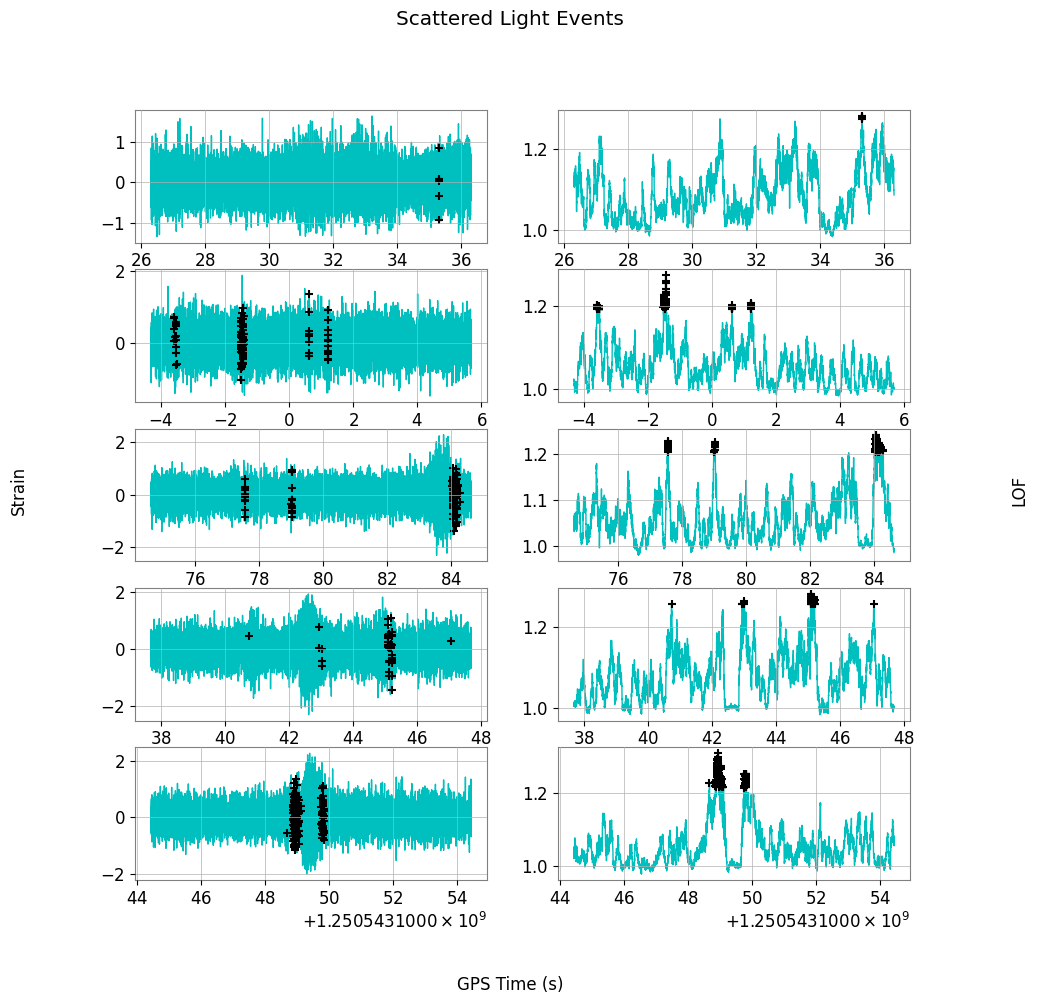

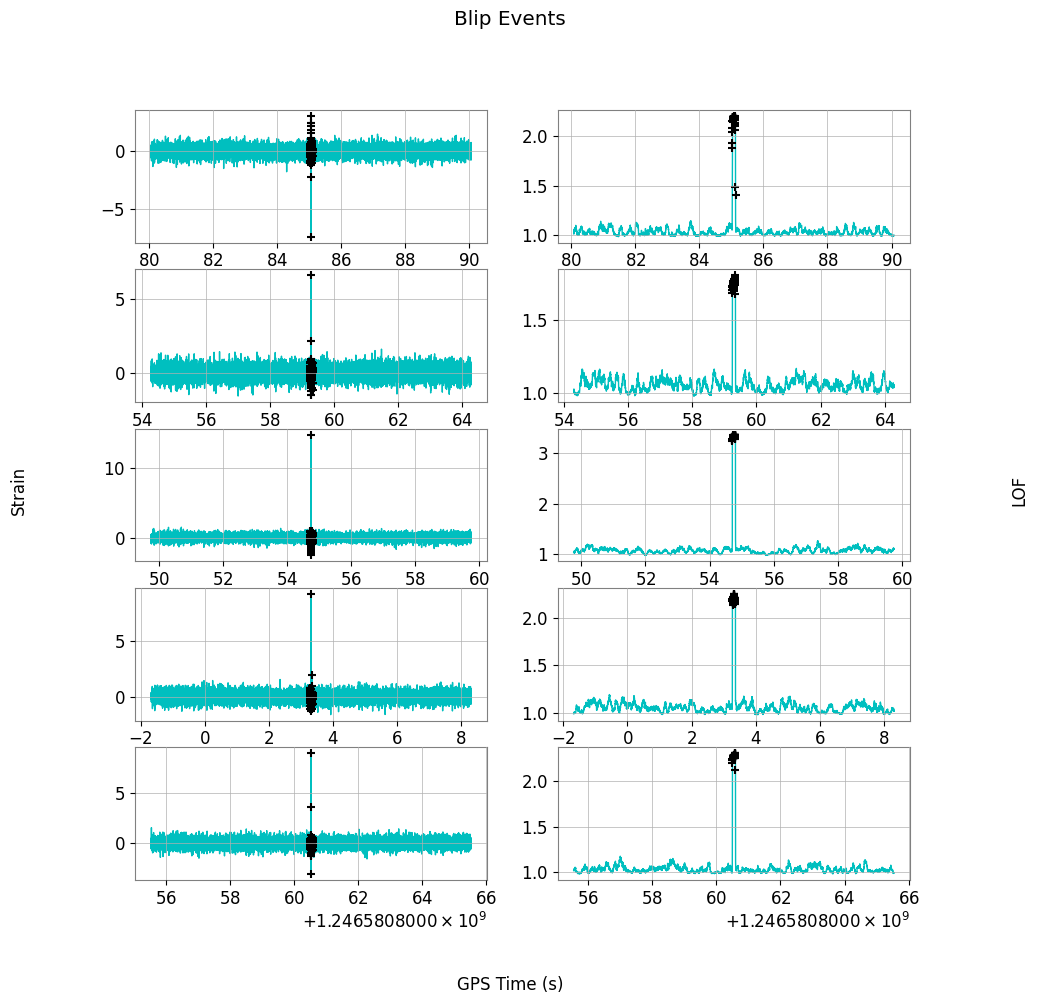

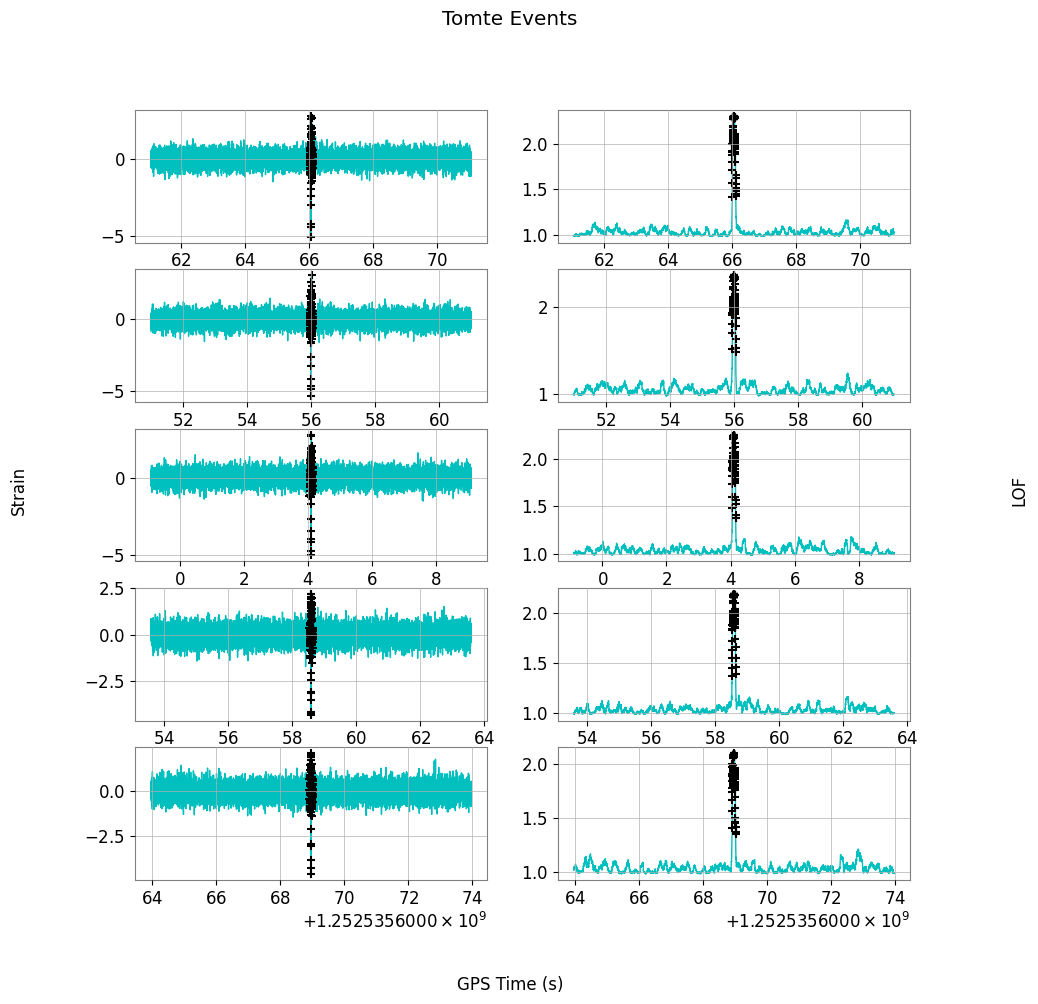

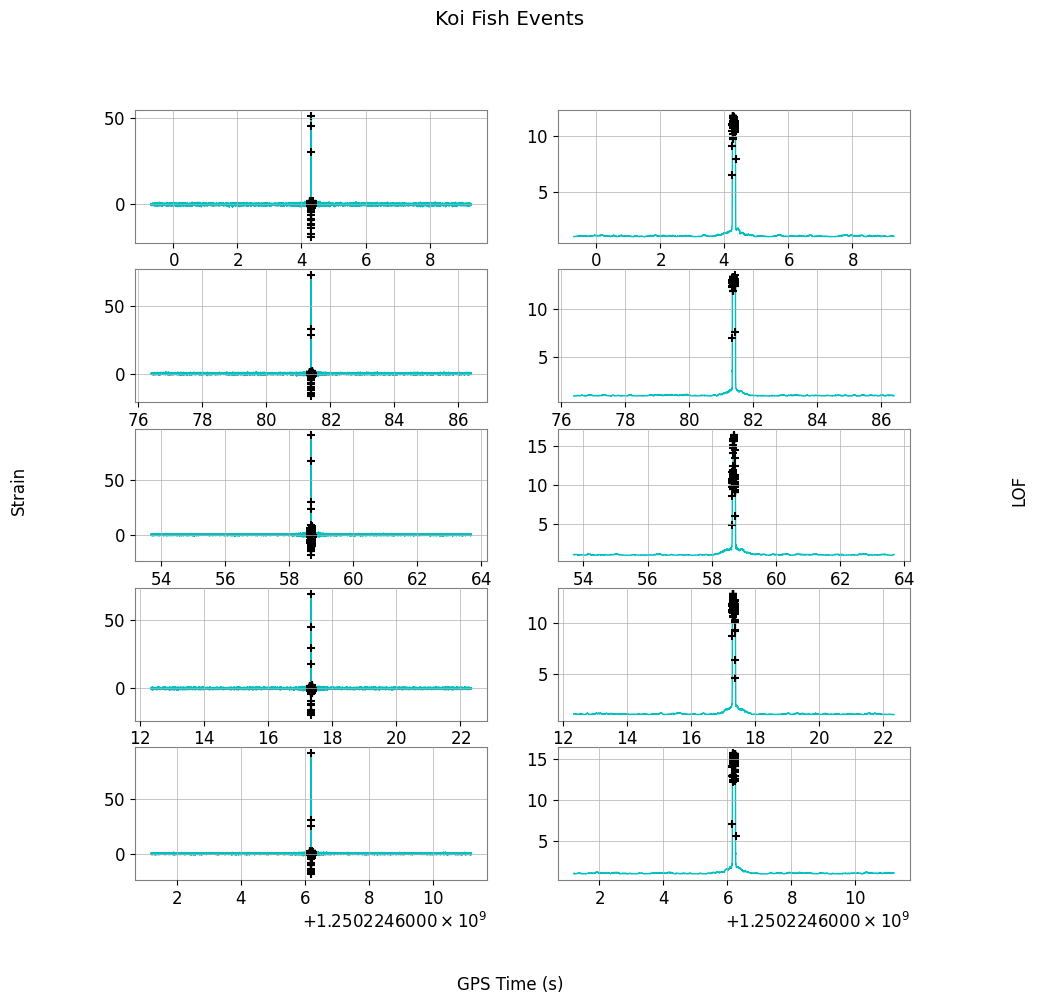

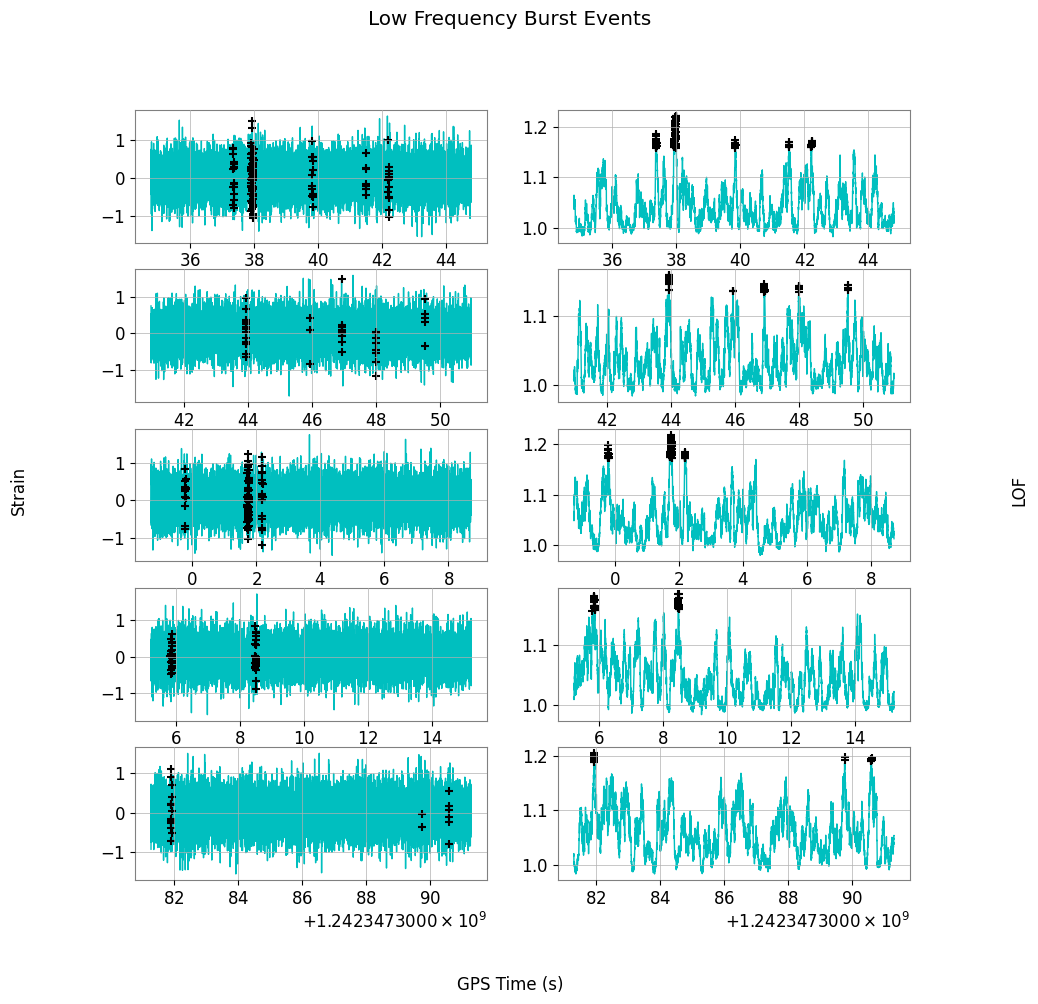

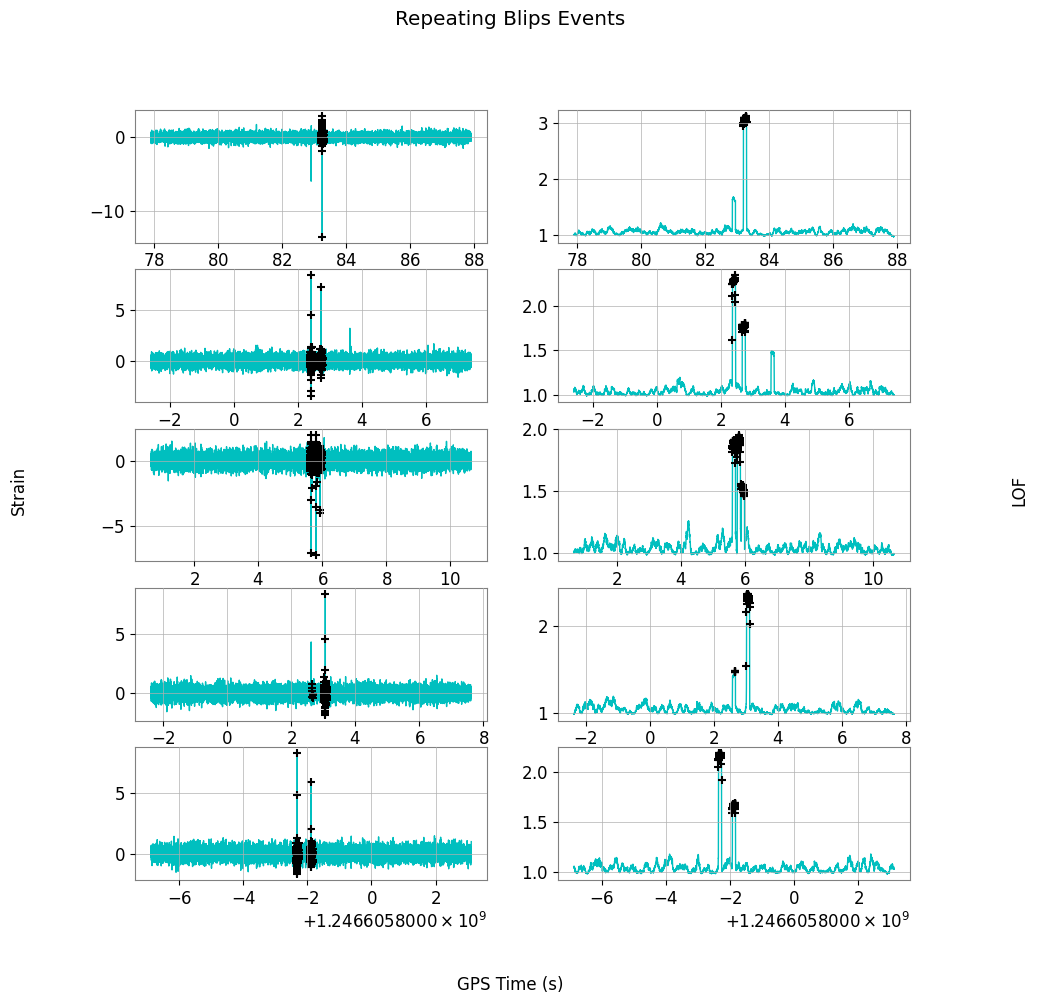

In [12]:
window_n = 100
clf = WindowedLocalOutlierFactor(window=window_n, crit_sigma=3, n_neighbors=20)

for k, (name, events) in enumerate(ALL.items()):
    print(f'NOW PLOTTING {name}s')
    rows = len(events)
    
    # LOF
    fig, axs = plt.subplots(rows, 2, figsize=(10, 2*rows))
    fig.suptitle(f'{name} Events')
    fig.text(0.5, 0, 'GPS Time (s)', ha='center')
    fig.text(0, 0.5, 'Strain', va='center', rotation='vertical')
    fig.text(1, 0.5, 'LOF', va='center', rotation='vertical')
    
    for i in tqdm(range(rows)):
        hdata = get_processed_event(DET, events[i], length=10, downsample=4)
        data = hdata.value
        times = hdata.times.value
        clf.fit(data, times)
        data, times = clf.get_truncated_data()
        plot_ts_outliers(clf, axs[i])

In [14]:
hdata = get_processed_event(DET, BLIP[0], length=4, downsample=1)

#fig, ax = plt.subplots(figsize=(8,8))
#tsne_plot = get_rolling_windows(hdata.value, 100)
#plot_2d_scatter(tsne_plot, ax)

#fn = 'data/H-H1_GWOSC_4KHZ_R1-1126257415-4.096.hdf5'
#ts = TimeSeries.read(fn,format='hdf5.losc')[::100]
#ts = ts[int(11*ts.size/22):int(13*ts.size/22)]
#ts = ts[int(ts.size/4):int(ts.size/2)]
#hdata = ts

In [15]:
## For the whole animation

anim = LOFMaxStdWindowAnimation(
    hdata.value,
    hdata.times.value,
    n_range=range(5,1001,10),
    interval=200
)
plt.close()
anim.show()

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
event = SCATTERED_LIGHT[2]
frame = 10

hdata = get_processed_event(DET, event, length=frame, downsample=1)
times = hdata.times.value
data = hdata.value
windows = get_rolling_windows(data, 1000)
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(windows)
lofs = -clf.negative_outlier_factor_

raw_data = get_raw_event(DET, event, length=frame, edges=0)
plot_kwargs = {'style': 'w-', 'alpha': 0.2}
middle = times[int(times.size/2)]
xlim = None #(middle - 0.5, middle + 0.5)
overlay_on_omega(times, lofs, raw_data, outseg=xlim, ylabel='LOF')

## TOF Stuff

In [ ]:
frame = 10
figures = []
ctof = TemporalOutlierFactor(dims=2, n_neighbors=20, event_length=2**13)

for k, (name, events) in enumerate(ALL.items()):
    print(f'NOW PLOTTING {name}s')
    rows = len(events)
    
    for i in tqdm(range(rows)):
        event = events[i]
        try:
            raw_data = get_raw_event(DET, event, length=frame, edges=0)
            hdata = get_processed_event(DET, event, length=frame, downsample=1)
        except ConnectionError as e:
            print(e)
            continue
        times = hdata.times.value
        data = hdata.value
        ctof.fit(data, times)
        data, times = ctof.get_truncated_data()
        
        fig = plt.figure(figsize=(12,6), constrained_layout=True)
        fig.suptitle(f'{name} {i+1}')
        gs = fig.add_gridspec(2, 4)
        rect1 = fig.add_subplot(gs[0,:2])
        rect1.set_ylabel('Strain')
        rect2 = fig.add_subplot(gs[1,:2], sharex=rect1)
        rect2.set_ylabel('TOF')
        rect2.set_xlabel('GPS Time (s)')
        square = fig.add_subplot(gs[:, 2:])
        square.set_xlabel('Time-Delay Embedded Phase Space')
        
        plot_ts_outliers(ctof, [rect1, rect2])
        plot_2d_phase_space(ctof.embedded_data, square, outlier_ids=ctof.tof_detections_)
        
        figures.append(fig)

In [ ]:
for fig in figures: fig.close()

In [ ]:
hdata = get_processed_event(DET, BLIP[0], length=4, downsample=1)
x0 = hdata.times.value[0] + 1.8
x1 = hdata.times.value[0] + 2.2

In [ ]:
anim = TOFEmbedDimsAnimation(
    hdata.value,
    hdata.times.value,
    n_range=range(3,21)
)
plt.close()
anim.show()

In [ ]:
event = SCATTERED_LIGHT[2]
frame = 4

hdata = get_processed_event(DET, event, length=frame, downsample=1)
times = hdata.times.value
data = hdata.value
res_df = detect_outlier(
    pd.DataFrame(data)[[0]], cutoff_n=100, k=20, embedding_dimension=3)
tofs = res_df.TOF_score

raw_data = get_raw_event(DET, event, length=frame, edges=0)
plot_kwargs = {'style': 'w-', 'alpha': 0.2}
middle = times[int(times.size/2)]
xlim = None #(middle - 0.5, middle + 0.5)
overlay_on_spectrogram(times, tofs, raw_data, outseg=xlim, ylabel='TOF')